In [1]:
#---------------------------------------#
# author : https://github.com/vidit1999 #
#---------------------------------------#

In [2]:
# https://www.kaggle.com/oktayozturk010/reddit-dad-jokes

In [3]:
import re
import nltk
import random
import joblib
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import minmax_scale, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from IPython.core import pylabtools

pylabtools.figsize(20, 5)
warnings.filterwarnings("ignore")
tqdm.pandas()

In [4]:
random.seed(0)
np.random.seed(0)

In [5]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vidit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vidit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vidit\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [8]:
df = pd.read_csv("../Data/reddit_dadjokes.csv")
df

,author,url,joke,score,date
0,VERBERD,https://old.reddit.com/r/dadjokes/comments/rvz...,"Doctor: ""So, you're telling me that you have a...",1,2022-01-04 17:16:02
1,MHSPres,https://old.reddit.com/r/dadjokes/comments/rvz...,A grizzly kept talking to me and annoyed me He...,1,2022-01-04 17:14:44
2,craftworldyt,https://old.reddit.com/r/dadjokes/comments/rvz...,I rubbed mayonnaise on my eyes Oh fuck oh shit...,1,2022-01-04 16:57:58
3,dynam0,https://old.reddit.com/r/dadjokes/comments/rvy...,What do you say to encourage an asteroid? Go l...,1,2022-01-04 16:41:01
4,aAsm321,https://old.reddit.com/r/dadjokes/comments/rvy...,They always ask me why my mood is always negat...,1,2022-01-04 16:39:49
...,...,...,...,...,...
216323,AOneArmedHobo,https://old.reddit.com/r/dadjokes/comments/1u4...,Farewell Dad Jokes... See you next year!,34,2014-01-01 00:19:53
216324,[deleted],https://old.reddit.com/r/dadjokes/comments/142...,Why do you always bang girls with big asses? S...,2,2012-11-30 19:10:40
216325,tali3sin,https://old.reddit.com/r/dadjokes/comments/lnx...,What's brown and sticky? A stick.,5,2011-10-25 02:49:08
216326,tali3sin,https://old.reddit.com/r/dadjokes/comments/lmk...,Show up at costume party without a shirt... .....,1,2011-10-24 00:51:14


In [9]:
lemma = WordNetLemmatizer()

In [10]:
tag_map = defaultdict(
    lambda : "n",
    {
        'J' : "a",
        'V' : "v",
        'R' : "r",
    }
)

In [11]:
def clean_sent(data):
    data = data.lower() # lowering
    data = data.encode("ascii", "ignore").decode() # non ascii chars
    data = re.sub(r'\n',' ', data) # remove new-line characters
    data = re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', ' ', data) # remove html tags and entities
    data = data.replace(r'amp', ' ') # remove 'amp' word
    data = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', data, flags=re.MULTILINE) # to remove links that start with HTTP/HTTPS in the tweet
    data = re.sub(r'[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', data, flags=re.MULTILINE) # to remove other url links
    data = re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|(\w+:\/\/\S+)","",data) # mentions and hashtags
    data = re.sub(r'\W', ' ', data) # special chars
    data = re.sub(r'\s+[a-zA-Z]\s+', ' ', data) # single characters
    data = re.sub(r'\^[a-zA-Z]\s+', ' ', data) # single char at first
    data = re.sub(r'[0-9]', ' ', data) # digits
    data = re.sub(r'\s+', ' ', data, flags=re.I) # multiple spaces
    return ' '.join([
        lemma.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(word_tokenize(data))
    ])

In [12]:
clean_sent(df.iloc[0]['joke'])

'doctor so you re tell me that you have problem with one of your ear be you sure me yes doctor m definite'

In [13]:
df.columns

Index(['author', 'url', 'joke', 'score', 'date'], dtype='object')

In [14]:
df.drop(columns=['author', 'url'], inplace=True)

In [15]:
df['date'] = pd.to_datetime(df['date']).astype('int64') // 10**9

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216328 entries, 0 to 216327
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   joke    216328 non-null  object
 1   score   216328 non-null  int64 
 2   date    216328 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 5.0+ MB


In [17]:
df.isna().sum()

joke     0
score    0
date     0
dtype: int64

In [18]:
df

,joke,score,date
0,"Doctor: ""So, you're telling me that you have a...",1,1641316562
1,A grizzly kept talking to me and annoyed me He...,1,1641316484
2,I rubbed mayonnaise on my eyes Oh fuck oh shit...,1,1641315478
3,What do you say to encourage an asteroid? Go l...,1,1641314461
4,They always ask me why my mood is always negat...,1,1641314389
...,...,...,...
216323,Farewell Dad Jokes... See you next year!,34,1388535593
216324,Why do you always bang girls with big asses? S...,2,1354302640
216325,What's brown and sticky? A stick.,5,1319510948
216326,Show up at costume party without a shirt... .....,1,1319417474


In [19]:
df.describe(percentiles=list(np.arange(0.1, 0.8, 0.1)) + list(np.arange(0.9, 1, 0.02))).T

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,90%,92%,94%,96%,98%,max
score,216328.0,5.393797e+01,5.646606e+02,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,2.100000e+01,2.900000e+01,4.200000e+01,7.300000e+01,2.160000e+02,3.250700e+04
date,216328.0,1.557088e+09,6.521195e+07,1.319397e+09,1.445821e+09,1.504420e+09,1.537880e+09,1.555161e+09,1.570059e+09,1.586269e+09,1.602204e+09,1.629991e+09,1.631975e+09,1.634179e+09,1.636490e+09,1.639015e+09,1.641318e+09


In [20]:
df['score'].value_counts()

1       115540
0        12982
2        11764
3         9174
4         6755
         ...  
5788         1
1170         1
1433         1
4690         1
1847         1
Name: score, Length: 2639, dtype: int64

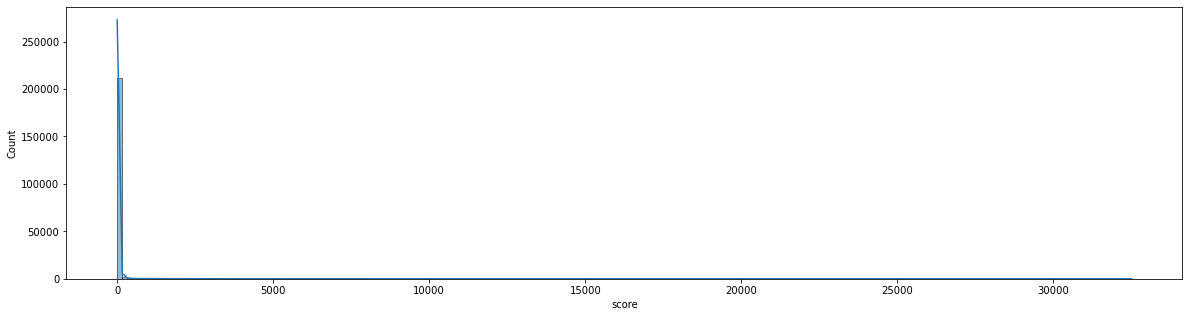

In [21]:
sns.histplot(df['score'], bins=200, kde=True)
plt.show()

In [22]:
df = df[(df['score'] > 500) & (df['score'] < 15000)]

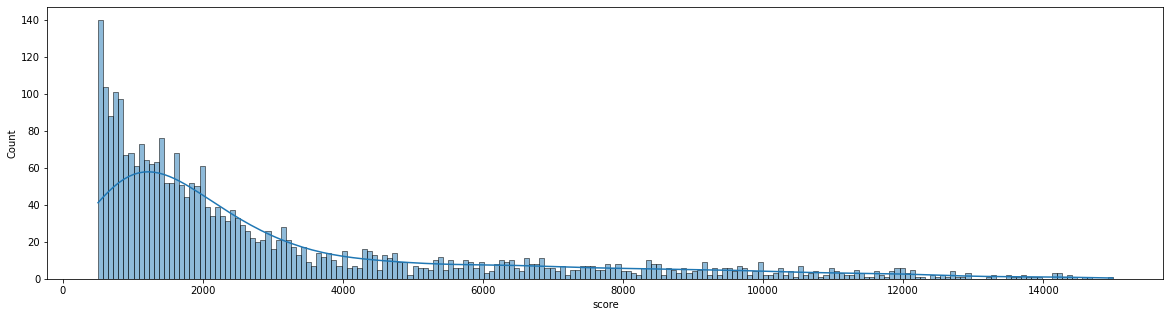

In [23]:
sns.histplot(df['score'], bins=200, kde=True)
plt.show()

In [24]:
# With date score has increased
# This increase in score is due to availablity and access to internet
# More people saw the joke, more people rated it
# Have to remove it

In [25]:
date_min_max = minmax_scale(df['date'])
df['date_adjusted_score'] = df['score'] / (date_min_max + date_min_max.mean())

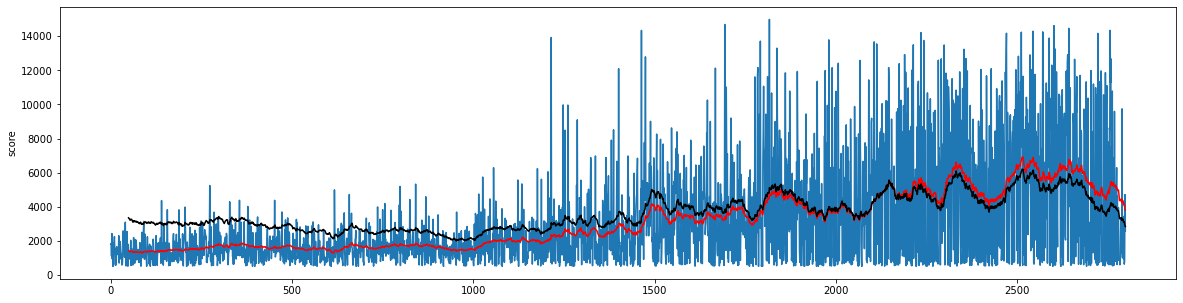

In [26]:
df_sort_by_date = df.sort_values('date')
x_range = list(range(len(df_sort_by_date)))

sns.lineplot(x=x_range, y=df_sort_by_date['score'])
sns.lineplot(x=x_range, y=df_sort_by_date['score'].rolling(window=50).mean(), color='r')
sns.lineplot(x=x_range, y=df_sort_by_date['date_adjusted_score'].rolling(window=50).mean(), color='k')
plt.show()

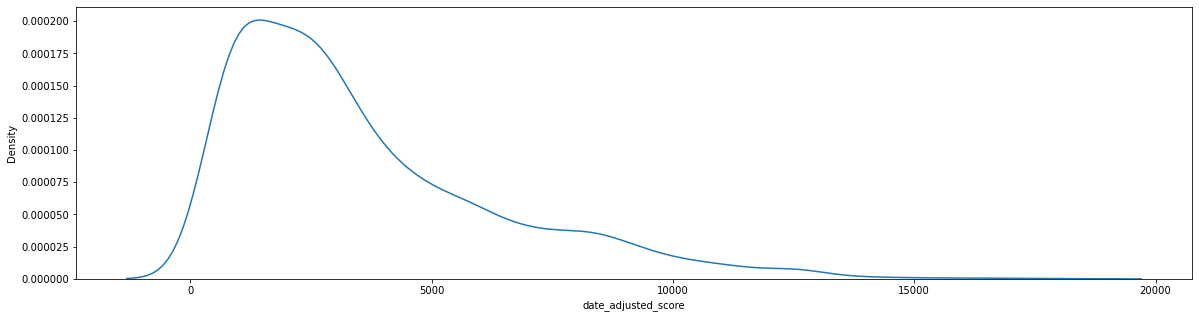

In [27]:
sns.kdeplot(df['date_adjusted_score'])
plt.show()

In [28]:
df['final_score'] = minmax_scale(df['date_adjusted_score'])

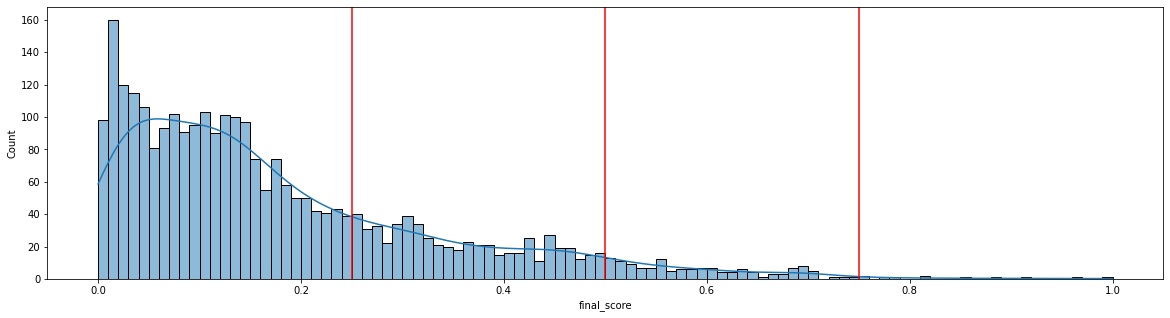

In [29]:
ax = sns.histplot(df['final_score'], bins=100, kde=True)
for i in range(1, 4):
    ax.axvline(i/4, color='r')
plt.show()

In [30]:
df.describe(percentiles=np.arange(0.1, 1, 0.1))

,score,date,date_adjusted_score,final_score
count,2800.000000,2.800000e+03,2800.000000,2800.000000
mean,3128.958214,1.492299e+09,3590.921661,0.181337
std,3026.402719,5.692101e+07,2806.648902,0.159648
min,501.000000,1.388600e+09,402.972917,0.000000
10%,677.000000,1.419058e+09,784.604072,0.021708
20%,900.800000,1.436009e+09,1214.398215,0.046156
30%,1200.000000,1.454493e+09,1745.206887,0.076349
40%,1521.600000,1.472855e+09,2263.716168,0.105843
50%,1901.000000,1.489271e+09,2751.038498,0.133563
60%,2404.800000,1.507955e+09,3388.899016,0.169846


In [31]:
# if final score
# greater than 3/4, rank = 'Very Good'
# greater than 2/4, rank = 'Good'
# greater than 1/4, rank = 'Satisfactory'
# else, rank = 'Bad'

In [32]:
def get_joke_rank(score):
    if score > 3/4:
        return 'Very Good'
    if score > 2/4:
        return 'Good'
    if score > 1/4:
        return 'Satisfactory'
    return 'Bad'

In [33]:
df['rank'] = df['final_score'].progress_apply(get_joke_rank)

  0%|          | 0/2800 [00:00<?, ?it/s]

In [34]:
df

,joke,score,date,date_adjusted_score,final_score,rank
4378,What do you call a cop in bed? (Lord help me) ...,2568,1638988507,1815.928724,0.080372,Bad
4409,I ran into the office this morning and switche...,4713,1638971382,3332.899538,0.166660,Bad
4431,What did Jay-Z call his wife before they got m...,816,1638955907,577.077210,0.009903,Bad
4446,Why’d the alternate universe Spider-Man do so ...,635,1638941466,449.091882,0.002623,Bad
4464,So I hired this dude to count people in the Bi...,3436,1638933360,2430.102420,0.115307,Bad
...,...,...,...,...,...,...
216110,"Dad jokes at the doctor Doctor, ""Hello, thanks...",943,1388896851,2270.430243,0.106225,Bad
216141,4 year old daughter just hit me with this one ...,2430,1388855222,5852.974386,0.310007,Satisfactory
216208,I told my first dad joke today. I didn't even ...,1110,1388746915,2676.369309,0.129315,Bad
216237,Brain Sucker I learned this from an old girlfr...,1847,1388674699,4456.481169,0.230572,Bad


In [35]:
df['rank'].value_counts()

Bad             2078
Satisfactory     573
Good             138
Very Good         11
Name: rank, dtype: int64

In [36]:
df['scaled_score'] = minmax_scale(df['score'])

In [37]:
df

,joke,score,date,date_adjusted_score,final_score,rank,scaled_score
4378,What do you call a cop in bed? (Lord help me) ...,2568,1638988507,1815.928724,0.080372,Bad,0.142670
4409,I ran into the office this morning and switche...,4713,1638971382,3332.899538,0.166660,Bad,0.290723
4431,What did Jay-Z call his wife before they got m...,816,1638955907,577.077210,0.009903,Bad,0.021742
4446,Why’d the alternate universe Spider-Man do so ...,635,1638941466,449.091882,0.002623,Bad,0.009249
4464,So I hired this dude to count people in the Bi...,3436,1638933360,2430.102420,0.115307,Bad,0.202581
...,...,...,...,...,...,...,...
216110,"Dad jokes at the doctor Doctor, ""Hello, thanks...",943,1388896851,2270.430243,0.106225,Bad,0.030508
216141,4 year old daughter just hit me with this one ...,2430,1388855222,5852.974386,0.310007,Satisfactory,0.133145
216208,I told my first dad joke today. I didn't even ...,1110,1388746915,2676.369309,0.129315,Bad,0.042035
216237,Brain Sucker I learned this from an old girlfr...,1847,1388674699,4456.481169,0.230572,Bad,0.092904


In [38]:
df['cleaned_joke'] = df['joke'].progress_apply(clean_sent)

  0%|          | 0/2800 [00:00<?, ?it/s]

In [39]:
df

,joke,score,date,date_adjusted_score,final_score,rank,scaled_score,cleaned_joke
4378,What do you call a cop in bed? (Lord help me) ...,2568,1638988507,1815.928724,0.080372,Bad,0.142670,what do you call cop in bed lord help me an un...
4409,I ran into the office this morning and switche...,4713,1638971382,3332.899538,0.166660,Bad,0.290723,i run into the office this morning and switch ...
4431,What did Jay-Z call his wife before they got m...,816,1638955907,577.077210,0.009903,Bad,0.021742,what do jay call his wife before they get marr...
4446,Why’d the alternate universe Spider-Man do so ...,635,1638941466,449.091882,0.002623,Bad,0.009249,whyd the alternate universe spider man do so w...
4464,So I hired this dude to count people in the Bi...,3436,1638933360,2430.102420,0.115307,Bad,0.202581,so hired this dude to count people in the bibl...
...,...,...,...,...,...,...,...,...
216110,"Dad jokes at the doctor Doctor, ""Hello, thanks...",943,1388896851,2270.430243,0.106225,Bad,0.030508,dad joke at the doctor doctor hello thanks for...
216141,4 year old daughter just hit me with this one ...,2430,1388855222,5852.974386,0.310007,Satisfactory,0.133145,year old daughter just hit me with this one he...
216208,I told my first dad joke today. I didn't even ...,1110,1388746915,2676.369309,0.129315,Bad,0.042035,i tell my first dad joke today didn even mean ...
216237,Brain Sucker I learned this from an old girlfr...,1847,1388674699,4456.481169,0.230572,Bad,0.092904,brain sucker learn this from an old girlfriend...


In [40]:
tfidf_vec = TfidfVectorizer()
tfidf = tfidf_vec.fit_transform(df['cleaned_joke'])
tfidf

<2800x6572 sparse matrix of type '<class 'numpy.float64'>'
	with 62432 stored elements in Compressed Sparse Row format>

In [41]:
kmeans = KMeans(n_clusters=4).fit(tfidf)
labels = kmeans.predict(tfidf)
labels

array([2, 1, 2, ..., 0, 3, 3])

In [42]:
X_tsvd_2d = pd.DataFrame(TruncatedSVD(n_components=2).fit_transform(tfidf), columns=['P1', 'P2'])
X_tsvd_2d

,P1,P2
0,0.116832,0.181191
1,0.205206,0.046163
2,0.123673,0.180026
3,0.110204,0.063453
4,0.287062,-0.021323
...,...,...
2795,0.167061,-0.015227
2796,0.304581,-0.136038
2797,0.383452,-0.059093
2798,0.329184,0.100234


In [43]:
X_tsvd_2d['original_rank'] = df['rank'].to_numpy()
X_tsvd_2d['kmeans_label'] = labels

In [44]:
X_tsvd_2d

,P1,P2,original_rank,kmeans_label
0,0.116832,0.181191,Bad,2
1,0.205206,0.046163,Bad,1
2,0.123673,0.180026,Bad,2
3,0.110204,0.063453,Bad,1
4,0.287062,-0.021323,Bad,3
...,...,...,...,...
2795,0.167061,-0.015227,Bad,1
2796,0.304581,-0.136038,Satisfactory,0
2797,0.383452,-0.059093,Bad,0
2798,0.329184,0.100234,Bad,3


<AxesSubplot:xlabel='P1', ylabel='P2'>

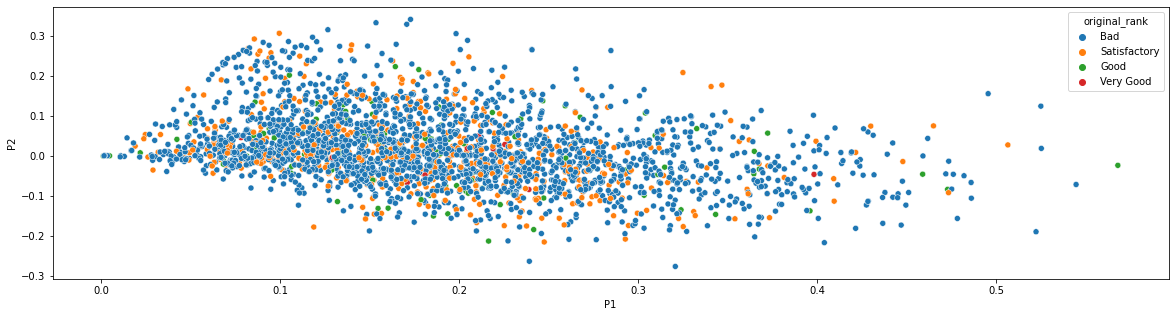

In [45]:
sns.scatterplot(x='P1', y='P2', data=X_tsvd_2d, hue='original_rank')

<AxesSubplot:xlabel='P1', ylabel='P2'>

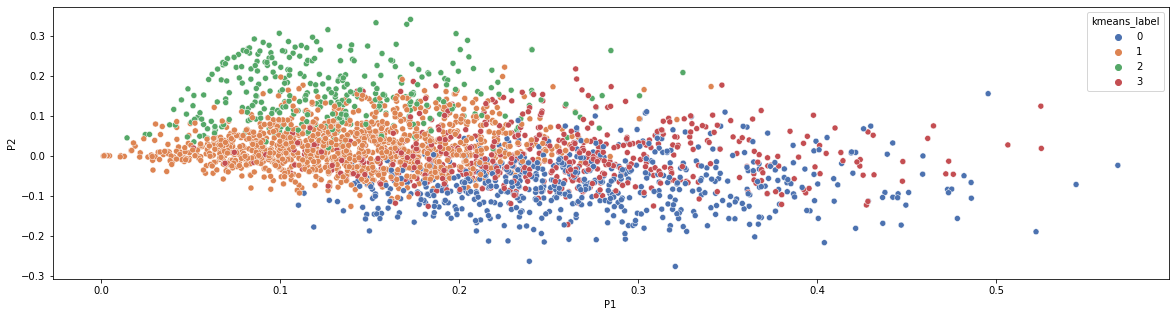

In [46]:
sns.scatterplot(x='P1', y='P2', data=X_tsvd_2d, hue='kmeans_label', palette="deep")

In [47]:
print(X_tsvd_2d['original_rank'].value_counts())
print(X_tsvd_2d['kmeans_label'].value_counts())

Bad             2078
Satisfactory     573
Good             138
Very Good         11
Name: original_rank, dtype: int64
1    1319
0     616
3     522
2     343
Name: kmeans_label, dtype: int64


In [48]:
df

,joke,score,date,date_adjusted_score,final_score,rank,scaled_score,cleaned_joke
4378,What do you call a cop in bed? (Lord help me) ...,2568,1638988507,1815.928724,0.080372,Bad,0.142670,what do you call cop in bed lord help me an un...
4409,I ran into the office this morning and switche...,4713,1638971382,3332.899538,0.166660,Bad,0.290723,i run into the office this morning and switch ...
4431,What did Jay-Z call his wife before they got m...,816,1638955907,577.077210,0.009903,Bad,0.021742,what do jay call his wife before they get marr...
4446,Why’d the alternate universe Spider-Man do so ...,635,1638941466,449.091882,0.002623,Bad,0.009249,whyd the alternate universe spider man do so w...
4464,So I hired this dude to count people in the Bi...,3436,1638933360,2430.102420,0.115307,Bad,0.202581,so hired this dude to count people in the bibl...
...,...,...,...,...,...,...,...,...
216110,"Dad jokes at the doctor Doctor, ""Hello, thanks...",943,1388896851,2270.430243,0.106225,Bad,0.030508,dad joke at the doctor doctor hello thanks for...
216141,4 year old daughter just hit me with this one ...,2430,1388855222,5852.974386,0.310007,Satisfactory,0.133145,year old daughter just hit me with this one he...
216208,I told my first dad joke today. I didn't even ...,1110,1388746915,2676.369309,0.129315,Bad,0.042035,i tell my first dad joke today didn even mean ...
216237,Brain Sucker I learned this from an old girlfr...,1847,1388674699,4456.481169,0.230572,Bad,0.092904,brain sucker learn this from an old girlfriend...


In [49]:
tsvd = TruncatedSVD(n_components=10)
le = LabelEncoder()

X = tsvd.fit_transform(tfidf)
y = le.fit_transform(df['rank'])

In [50]:
X.shape, y.shape

((2800, 10), (2800,))

In [51]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [52]:
np.unique(y, return_counts=True), np.unique(y_resampled, return_counts=True)

((array([0, 1, 2, 3]), array([2078,  138,  573,   11], dtype=int64)),
 (array([0, 1, 2, 3]), array([2078, 2078, 2078, 2078], dtype=int64)))

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3)

In [54]:
classifiers = {
    "svm": SVC(),
    "random_forest": RandomForestClassifier(),
    "decision_tree": DecisionTreeClassifier(),
    "sgd": SGDClassifier(),
    "mlp": MLPClassifier(),
    "ada_boost": AdaBoostClassifier(),
    "xg_boost": XGBClassifier(),
    "gaussian_nb": GaussianNB(),
    "bernouli_nb": BernoulliNB(),
    "lgbm": LGBMClassifier()
}

In [55]:
train_test_results = []

for name, clf in tqdm(classifiers.items()):
    clf.fit(X_train, y_train)
    train_test_results.append({
        "model": name,
        "train_score": clf.score(X_train, y_train),
        "test_score": clf.score(X_test, y_test)
    })

  0%|          | 0/10 [00:00<?, ?it/s]

[17:00:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [56]:
train_test_results = pd.DataFrame(train_test_results)
train_test_results.sort_values(['test_score', 'train_score'], ascending=False)

,model,train_score,test_score
1,random_forest,0.998453,0.862069
6,xg_boost,0.997250,0.832398
9,lgbm,0.991234,0.823577
2,decision_tree,0.998453,0.727346
0,svm,0.702303,0.662791
4,mlp,0.650911,0.609062
5,ada_boost,0.523891,0.489976
7,gaussian_nb,0.450155,0.450281
3,sgd,0.376934,0.376905
8,bernouli_nb,0.323479,0.322374


<AxesSubplot:ylabel='model'>

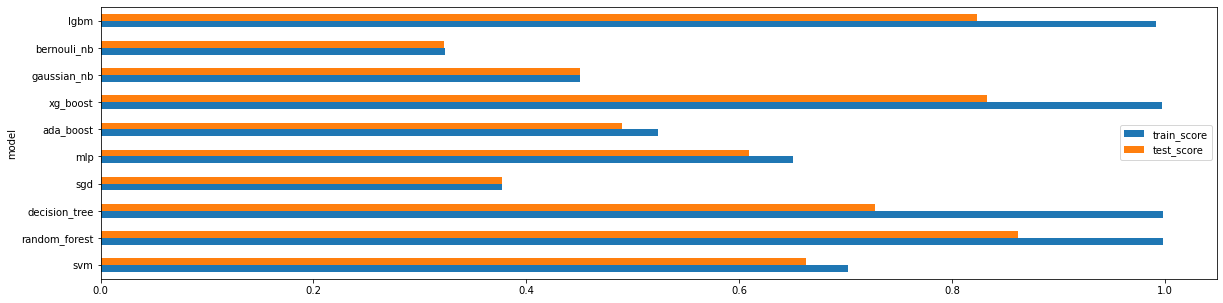

In [57]:
train_test_results.set_index('model').plot(kind='barh')

In [58]:
rfc = RandomForestClassifier().fit(X_train, y_train)

In [59]:
y_pred = rfc.predict(X_test)

In [60]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7862    0.6867    0.7331       632
           1     0.9223    0.9363    0.9292       659
           2     0.7458    0.8113    0.7772       604
           3     0.9724    1.0000    0.9860       599

    accuracy                         0.8581      2494
   macro avg     0.8567    0.8586    0.8564      2494
weighted avg     0.8571    0.8581    0.8563      2494



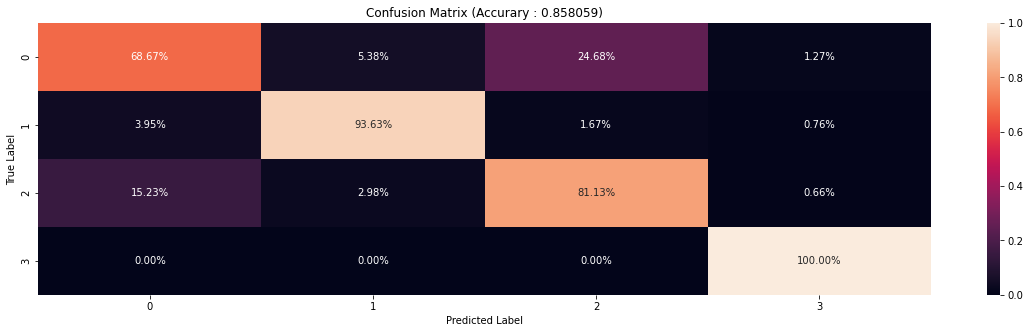

In [61]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, fmt=".2%")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

ax.set_title(f"Confusion Matrix (Accurary : {accuracy_score(y_test, y_pred):.6f})")

plt.show()

In [62]:
joblib.dump([rfc, tfidf_vec, kmeans, tsvd, le], "../Data/dad_joke_score_prediction.pkl")

['../Data/dad_joke_score_prediction.pkl']